In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import minimize
import emcee
import corner
from scipy.optimize import curve_fit
import math
from itertools import product

In [2]:
# path of fits

fits_file = r'D:/astro/data/Field_35_logNH2.fits'

# the range of column density in the histogram

filtered_data_min=21.5
filtered_data_max=23

num_bins = 30

#the range of column density of curve_fit and MCMC

fit_min=21.6
fit_max=22.45

# Initial parameters [mu, sigma_eta, M, alpha, eta_t] for curve_fit

initial_guess = [22, 0.09, 11, -3, 22.3]

Filename: D:/astro/data/Field_35_logNH2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  image         1 PrimaryHDU      45   (894, 924)   float64   
None
curve_fit parameter:
mu = 21.850
sigma_eta = 0.203
M = 0.055
alpha = -6.776
eta_t = 22.249


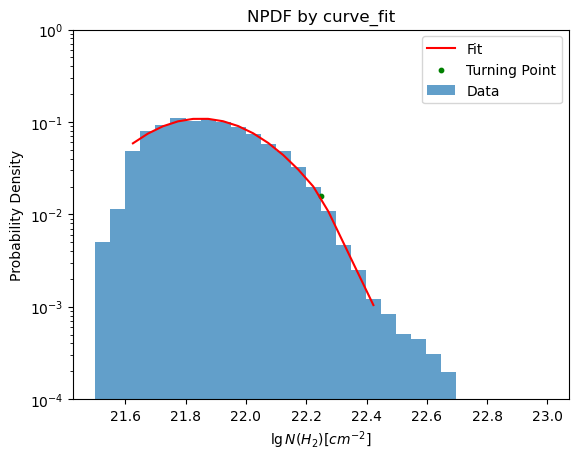

In [3]:
# Read input images

hdul = fits.open(fits_file)
data = hdul[0].data
hdul.close()
print(hdul.info())

# Expands a two-dimensional array into a one-dimensial array

flattened_data = data.flatten()
flattened_data = flattened_data[~np.isnan(flattened_data)]
filtered_data = flattened_data[(flattened_data >= filtered_data_min) & (flattened_data <= filtered_data_max)]

def lognormal_powerlaw(
                        eta,
                        mu,
                        sigma_eta,
                        M,
                        alpha,
                        eta_t):
    
    ''' 
        explain parameters:
        eta      :the x of the N-PDF
        mu       :the mean of the lognormal function
        sigma_eta:the dimensionless dispersion of the lognormal function
        M        :the amplitude of the N-PDF
        alpha    :the slope of power-law tail
        eta_t    :the transition point
        
    '''
    
    lognormal_part = np.where(eta <= eta_t, 
        M * (2 * np.pi * sigma_eta ** 2) ** (-0.5) * np.exp(-0.5 * ((eta - mu) ** 2) / (sigma_eta ** 2)), 0)
    powerlaw_part = np.where(eta > eta_t, 
        M * (2 * np.pi * sigma_eta ** 2) ** (-0.5) * np.exp(-0.5 * ((eta_t - mu) ** 2) / (sigma_eta ** 2)) * 10 **(alpha*(eta-eta_t)), 0)
    return lognormal_part + powerlaw_part

# Calculate histogram

counts, bin_edges = np.histogram(filtered_data, bins=num_bins, density=False)

# Calculate normalization factor

total_count = np.sum(counts)

# Normalize counts

normalized_counts = counts / total_count

# Calculate the midpoints of each bin in the histogram

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

valid_indices = (bin_centers >= fit_min) & (bin_centers <= fit_max)
new_bin_centers = bin_centers[valid_indices]
new_normalized_counts = normalized_counts[valid_indices]

# Fit the data

popt, pcov = curve_fit(lognormal_powerlaw, new_bin_centers, new_normalized_counts, p0=initial_guess, maxfev=10000)

# Extract fitting parameters

mu, sigma_eta, M, alpha, eta_t = popt

# Generate fitting curve


y_fit = lognormal_powerlaw(new_bin_centers, *popt)

# Ensure y_fit does not contain zero values

y_fit = np.maximum(y_fit, 1e-10)

print("curve_fit parameter:")
print(f"mu = {mu:.3f}")
print(f"sigma_eta = {sigma_eta:.3f}")
print(f"M = {M:.3f}")
print(f"alpha = {alpha:.3f}")
print(f"eta_t = {eta_t:.3f}")

# Plot histogram and fit curve

# 假设转折点的横坐标已知
turning_point_x = eta_t

# 找到对应的 y 值
turning_point_y = lognormal_powerlaw(turning_point_x, *popt)
plt.figure()
plt.bar(bin_centers, normalized_counts, width=np.diff(bin_edges), edgecolor='none', alpha=0.7, label='Data')
plt.plot(new_bin_centers, y_fit, 'r-', label='Fit')
plt.scatter(turning_point_x, turning_point_y, color='green', s=10, label='Turning Point')
plt.xlabel(r'$\lg N(H_2) [cm^{-2}]$')
plt.ylabel('Probability Density')
plt.yscale('log')
plt.ylim(1e-4, 1) 
plt.title('NPDF by curve_fit')
plt.legend()
plt.show()



100%|██████████| 8000/8000 [00:04<00:00, 1820.04it/s]


MCMC results:
mu = 21.854 ± 0.007
sigma_eta = 0.203 ± 0.007
M = 0.055 ± 0.002
alpha = -6.343 ± 0.317
eta_t = 22.232 ± 0.028
log_f = -2.561 ± 0.220


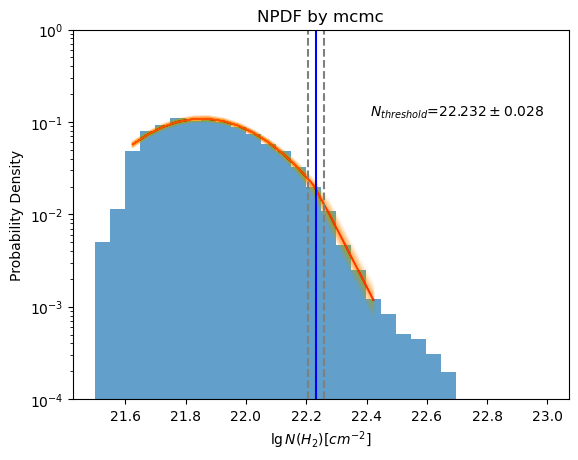

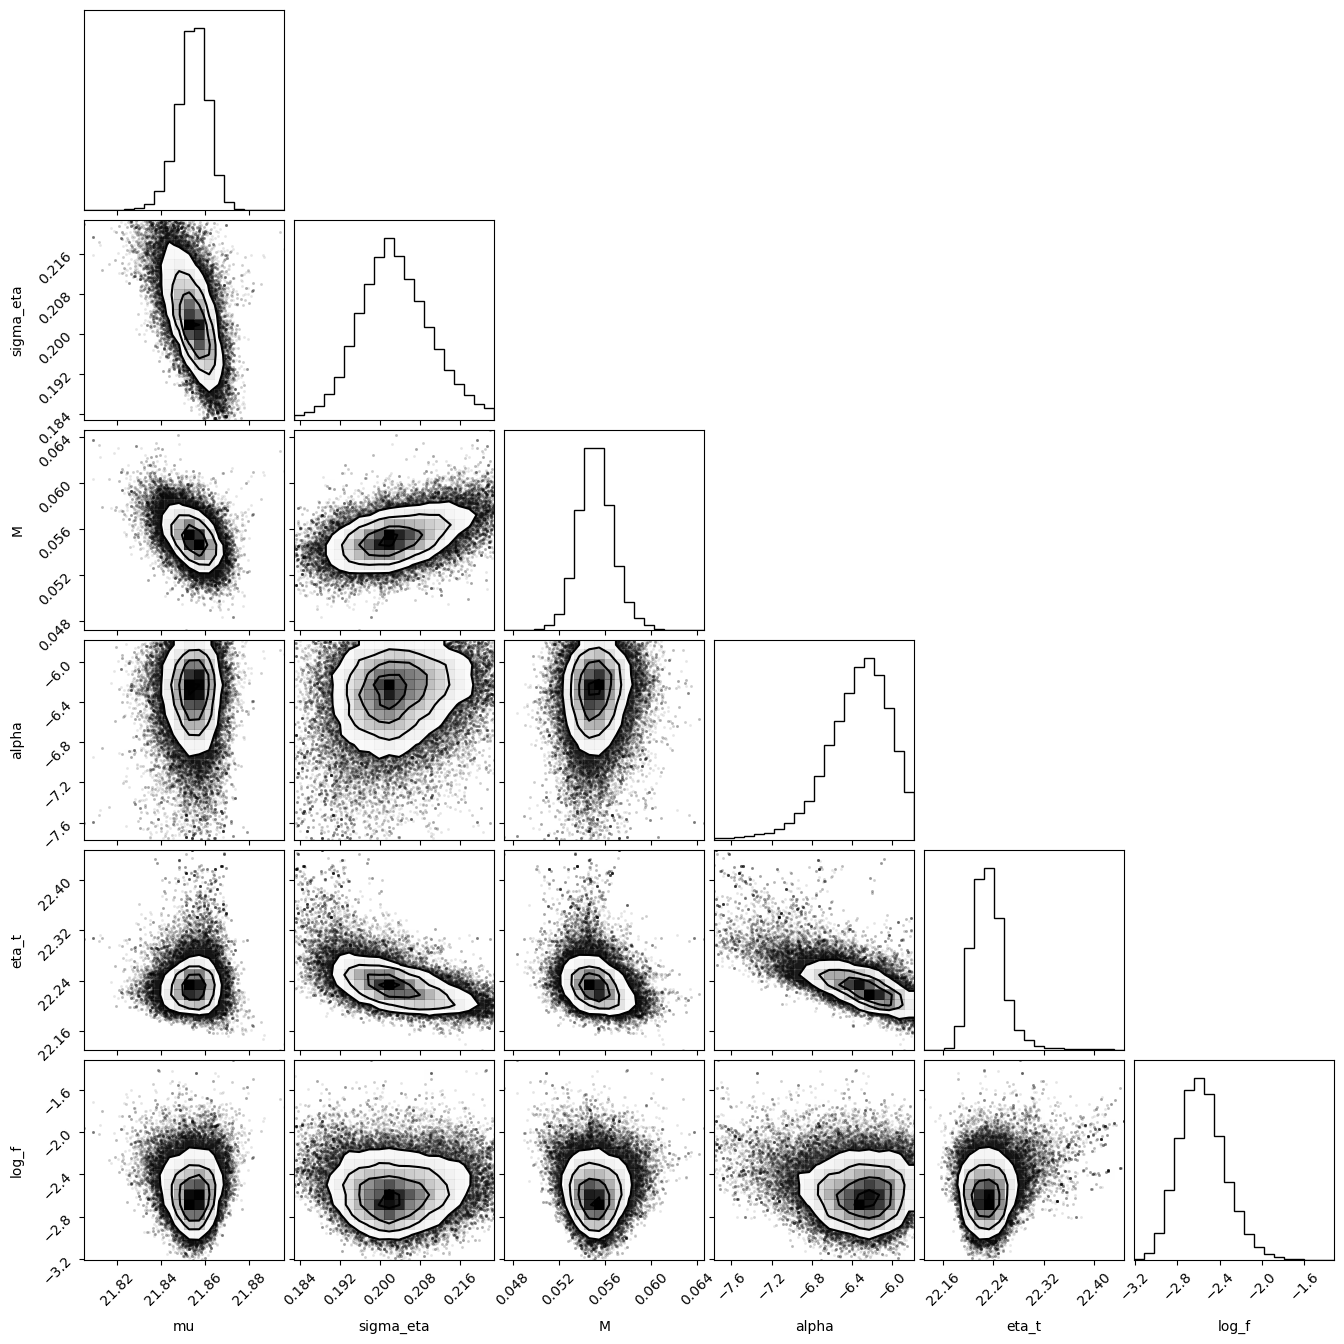

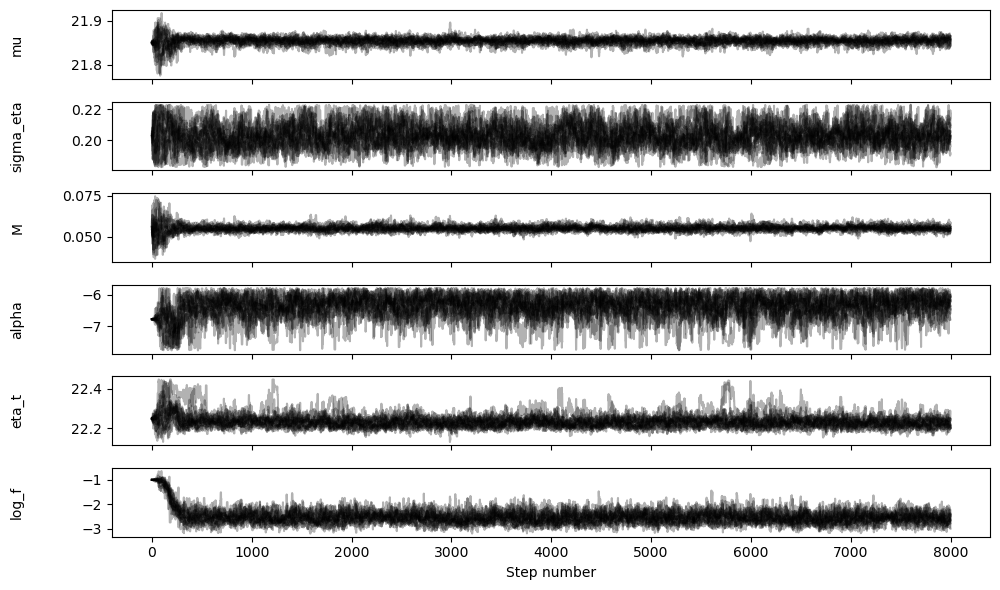

In [4]:
# Generate some synthetic data from the model

yerr = np.sqrt(new_normalized_counts/total_count)
eta_synthetic = np.linspace(fit_min, fit_max, num_bins)
model_synthetic = lognormal_powerlaw(eta_synthetic, *popt)

# Define likelihood

def log_likelihood(theta, eta, data):
    mu, sigma_eta, M, alpha, eta_t, log_f = theta
    model = lognormal_powerlaw(eta, mu, sigma_eta, M, alpha, eta_t)
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f) 
    return -0.5 * np.sum((data - model) ** 2 / sigma2 + np.log(sigma2))

# Fit with mcmc

def log_prior(theta, popt):
    mu, sigma_eta, M, alpha, eta_t, log_f = theta
    if (popt[0] - 0.1 < mu < popt[0] + 0.1 and
        popt[1] - 0.02 < sigma_eta < popt[1] + 0.02 and
        popt[2] - 0.02 < M < popt[2] + 0.02 and
        popt[3] - 1 < alpha < popt[3] + 1 and
        popt[4] - 0.2 < eta_t < popt[4] + 0.2): 
        return 0.0
    return -np.inf

def log_probability(theta, eta, data):
    lp = log_prior(theta,popt)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, eta, data)


# MCMC parameter

nwalkers = 16
ndim     = 6
nsteps   = 8000  
burnin   = 200
popt =popt.tolist()
popt.append(-1.)
popt=np.array(popt)
pos = popt + 10**-3 * np.random.randn(nwalkers, ndim)

# Define sampler

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(new_bin_centers, new_normalized_counts))

# sampling

sampler.run_mcmc(pos, nsteps, progress=True)

# discard burnin

samples = sampler.get_chain(discard=burnin, flat=True)

# Calculate the mean and standard deviation of the parameters

param_means = np.mean(samples, axis=0)
param_stds = np.std(samples, axis=0)
labels = ["mu", "sigma_eta", "M", "alpha", "eta_t","log_f"]


print("MCMC results:")
for i in range(ndim):
    print(f"{labels[i]} = {param_means[i]:.3f} ± {param_stds[i]:.3f}")

# Generate fitting curve

y_mcmc = lognormal_powerlaw(new_bin_centers, *param_means[:-1])

# plot NPDF by mcmc

plt.figure()
plt.bar(bin_centers, normalized_counts, width=np.diff(bin_edges), edgecolor='none', alpha=0.7)
plt.plot(new_bin_centers, y_mcmc, 'r-')
plt.xlabel(r'$\lg N(H_2) [cm^{-2}]$')
plt.ylabel('Probability Density')
plt.yscale('log')
plt.ylim(1e-4, 1) 
plt.title('NPDF by mcmc')

# plot errs by the stds of paras
param1_vals = np.linspace(param_means[0] - param_stds[0], param_means[0] + param_stds[0], 3)
param2_vals = np.linspace(param_means[1] - param_stds[1], param_means[1] + param_stds[1], 3)
param3_vals = np.linspace(param_means[2] - param_stds[2], param_means[2] + param_stds[2], 3)
param4_vals = np.linspace(param_means[3] - param_stds[3], param_means[3] + param_stds[3], 3)
param5_vals = np.linspace(param_means[4] - param_stds[4], param_means[4] + param_stds[4], 3)

for params in product(param1_vals, param2_vals, param3_vals, param4_vals, param5_vals):
    y_values = lognormal_powerlaw(new_bin_centers, *params)  
    plt.plot(new_bin_centers, y_values, alpha=0.01, color='orange')


# plot the mean and the standard of the transition point
mu = param_means[4]
sigma = param_stds[4]
plt.text(0.95, 0.8, r'$N_{threshold}$='+ f'$ {mu:.3f} \pm {sigma:.3f}$', 
         ha='right', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.axvline(param_means[4], color='blue', linestyle='-')
plt.axvline(param_means[4] + param_stds[4], color='gray', linestyle='--')
plt.axvline(param_means[4] - param_stds[4], color='gray', linestyle='--')


plt.show()

# plot corner

fig = corner.corner(samples, labels=["mu", "sigma_eta", "M", "alpha", "eta_t", "log_f"])
plt.show()

# Plot chains

fig, axes = plt.subplots(ndim, figsize=(10, 6), sharex=True)

# Loop over each parameter dimension

for i in range(ndim):
    ax = axes[i]
    
    # Loop over each walker and plot their chain
    
    for walker in range(nwalkers):
        ax.plot(sampler.chain[walker, :, i], color="k", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

# Set x-axis label to indicate step number

axes[-1].set_xlabel("Step number")
plt.tight_layout()
plt.show()